# Exploratory data analysis for EMBI Basis Points (BPS) dataset

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

The first step is a pre-processing and cleaning of the dataset.

In [2]:
file = open('config1.json', encoding='utf-8')
config_file = json.load(file)
file.close()

In [3]:
def cleanning_data(data):
    clean = data.copy()
    sort_to = ''

    for i in config_file:
        if (config_file[i] == 'dateTime'):
            clean[i] = pd.to_datetime(clean[i], dayfirst=True)
            sort_to = i
        elif (config_file[i] == 'str'):
            clean[i] = clean[i].str.strip()
        elif (config_file[i] == 'float'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x, True))
        elif (config_file[i] == 'int'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x))

    return clean.sort_values(by=sort_to, ascending=True)

def number_cleanning(num, isFloat=False):
    thou_sep = ','
    ans = str(num).lower()
    ans = ans.replace(thou_sep, '')

    tens = dict(k='E+03', m='E+06', b='E+09')
    for word, exp in tens.items():
        ans = ans.replace(word, exp)

    regex_num = '^\D*|\D*$'
    ans = re.sub(regex_num, '', ans)

    if (isFloat):
        return float(ans)
    else:
        return int(float(ans)//1)

In [4]:
path = '../data/raw/EMBI.csv'
df = pd.read_csv(path, sep=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Trade Date        293 non-null    object
 1   Strip Sprd (bps)  293 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [5]:
df2 = cleanning_data(df)
df2

,Trade Date,Strip Sprd (bps)
0,1997-12-31,286
1,1998-01-30,310
2,1998-02-27,266
3,1998-03-31,285
4,1998-04-30,312
...,...,...
288,2021-12-31,353
289,2022-01-31,374
290,2022-02-28,385
291,2022-03-31,338


Now the row file is imported.

In [6]:
df_embi = pd.DataFrame()
df_embi['Date'] = pd.to_datetime(df['Trade Date'])
df_embi['Instrument Name'] = 'EMBI'
df_embi['Year'] = df_embi['Date'].dt.year
df_embi['Month'] = df_embi['Date'].dt.month
df_embi['Day'] = df_embi['Date'].dt.day
df_embi['BPS'] = df['Strip Sprd (bps)']
df_embi['Percentage Terms'] = df_embi['BPS'] / 100.0
df_embi

,Date,Instrument Name,Year,Month,Day,BPS,Percentage Terms
0,1997-12-31,EMBI,1997,12,31,286,2.86
1,1998-01-30,EMBI,1998,1,30,310,3.10
2,1998-02-27,EMBI,1998,2,27,266,2.66
3,1998-03-31,EMBI,1998,3,31,285,2.85
4,1998-04-30,EMBI,1998,4,30,312,3.12
...,...,...,...,...,...,...,...
288,2021-12-31,EMBI,2021,12,31,353,3.53
289,2022-01-31,EMBI,2022,1,31,374,3.74
290,2022-02-28,EMBI,2022,2,28,385,3.85
291,2022-03-31,EMBI,2022,3,31,338,3.38


In [7]:
df_embi = df_embi.set_index('Date')
df_embi.dropna(inplace=True)
df_embi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 1997-12-31 to 2022-04-29
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Instrument Name   293 non-null    object 
 1   Year              293 non-null    int64  
 2   Month             293 non-null    int64  
 3   Day               293 non-null    int64  
 4   BPS               293 non-null    int64  
 5   Percentage Terms  293 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 16.0+ KB


The Colombian Emerging Markets Bond Index is the main indicator of country risk, mainly determined by the international investor's risk appetite, whose response is non-linear and depends on the government's fiscal attitude. These data are structured as shown below.This dataset has a sample by month.

In [8]:
df_embi

,Instrument Name,Year,Month,Day,BPS,Percentage Terms
Date,,,,,,
1997-12-31,EMBI,1997,12,31,286,2.86
1998-01-30,EMBI,1998,1,30,310,3.10
1998-02-27,EMBI,1998,2,27,266,2.66
1998-03-31,EMBI,1998,3,31,285,2.85
1998-04-30,EMBI,1998,4,30,312,3.12
...,...,...,...,...,...,...
2021-12-31,EMBI,2021,12,31,353,3.53
2022-01-31,EMBI,2022,1,31,374,3.74
2022-02-28,EMBI,2022,2,28,385,3.85


In [9]:
df_embi.describe()

,Year,Month,Day,BPS,Percentage Terms
count,293.000000,293.000000,293.000000,293.000000,293.000000
mean,2009.627986,6.467577,29.843003,323.211604,3.232116
std,7.065363,3.477394,2.051376,189.177156,1.891772
min,1997.000000,1.000000,1.000000,112.000000,1.120000
25%,2004.000000,3.000000,29.000000,184.000000,1.840000
50%,2010.000000,6.000000,30.000000,241.000000,2.410000
75%,2016.000000,9.000000,31.000000,425.000000,4.250000
max,2022.000000,12.000000,31.000000,1066.000000,10.660000


For an initial analysis you can observe some basic statistical data that give a general context of the information with which you are going to work

## Plotting Stock Price Trend and Returns

Based on the economic context of the data, the variables that are of greatest interest to analyze the performance of ISA's share value are the BPS [%] because it shows the final daily valuation and the returns that allow us to visualize the rate of change of action from day to day.


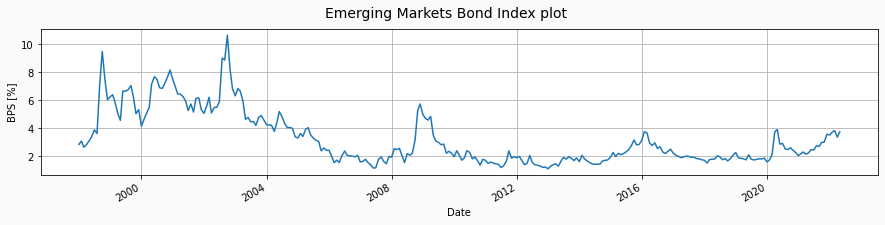

In [10]:
fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 3), facecolor=(.98, .98, .98))
fig1.suptitle('Emerging Markets Bond Index plot', fontsize=14)
ax1 = df_embi.plot(use_index=True, y='Percentage Terms', style=['-'], ylabel='BPS [%]', legend=False, grid=True, ax=axes1);

The behavior of the investment index, according to the registered data, had a greater fluctuation before 2004, but with an average of around 6 percentage points. After that, it had a constant death, however, later around 2008 it stabilized again, now with an average of around 2 percentage points, which, omitting some peaks, has remained constant until today.

## Dotted Plot

Again, the dot plot allows us to see in a little more detail the gap between one sample and another, also allowing us to get an idea of how missing data can affect the around 16 years of information we have.

<Figure size 432x288 with 0 Axes>

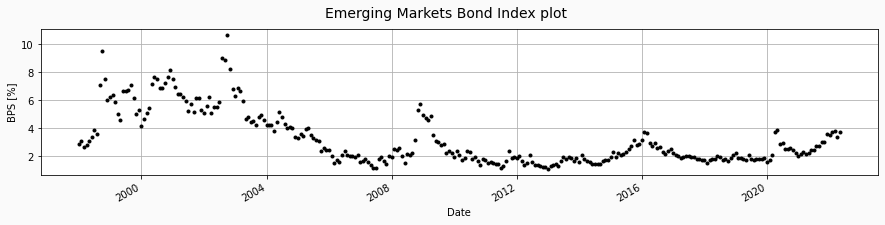

In [11]:
plt.figure()
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 3), facecolor=(.98, .98, .98))
fig2.suptitle('Emerging Markets Bond Index plot', fontsize=14)
ax3 = df_embi['Percentage Terms'].plot(style='k.', grid=True, ylabel='BPS [%]', ax=axes2);

## Histogram of Emerging Markets Bond Index

Subsequently, we proceed to generate the histogram of our data to perform a distribution analysis.

In the case of the index, a strong inclination to the left is seen, which is an expected behavior according to the analysis carried out on its graph over time, a predominant value around 2 percentage points.

<Figure size 432x288 with 0 Axes>

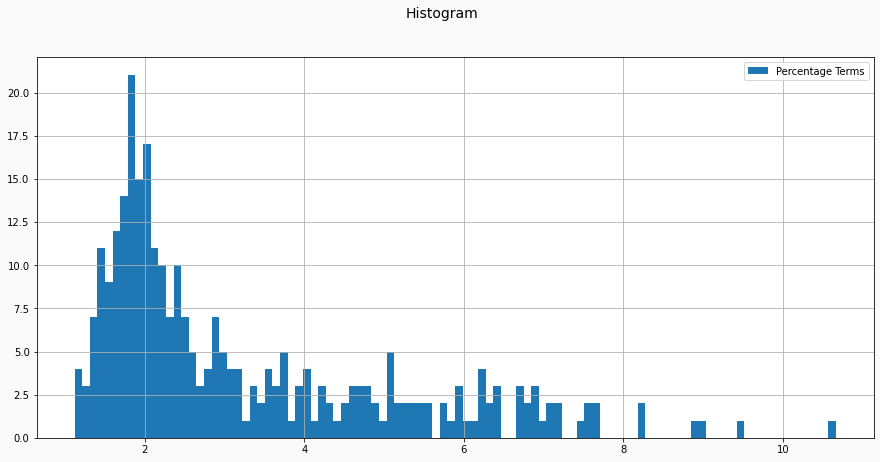

In [12]:
plt.figure()
fig3, axes3 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig3.suptitle('Histogram', fontsize=14)
ax5 = df_embi['Percentage Terms'].hist(bins=100, legend=True, ax=axes3);

## Kernel Density Plot

Continuing with the previous analysis, a better way to understand the behavior of the price and the variation is by analyzing its density, which by smoothing some data gives us an idea of the distribution of the data and allows us to analyze where the confluence has been greater.

<Figure size 432x288 with 0 Axes>

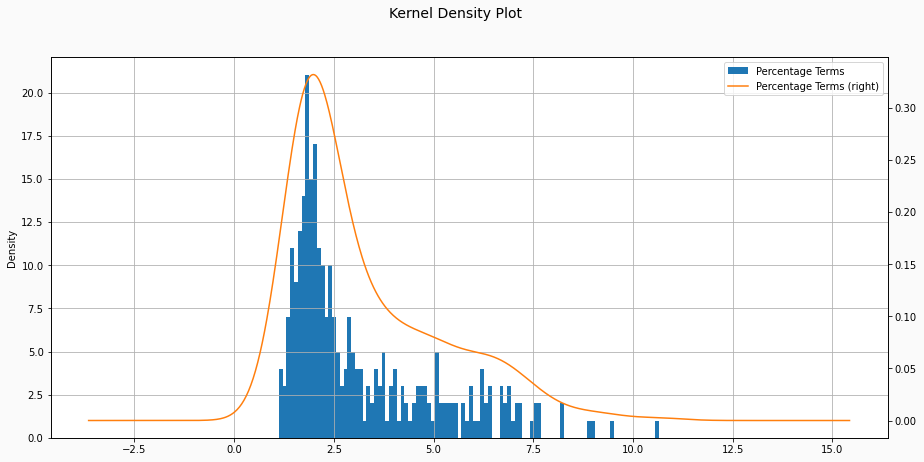

In [13]:
plt.figure()
fig4, axes4 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig4.suptitle('Kernel Density Plot', fontsize=14)
ax5 = df_embi['Percentage Terms'].plot(kind='hist', bins=100, legend=True, ax=axes4)
ax6 = df_embi['Percentage Terms'].plot(kind='kde', grid=True, legend=True, ax=axes4, secondary_y=True);

## Plotting Moving Average

Another useful strategy for time series preprocessing is to reduce the variance of the data by applying filters. Maintaining the same structure, the first approximation that we present is the moving average, composed of a window of 6 samples (representing 6 months of data) to analyze the average evolution of the previous data.

However, the application of low order filtering models implies, although with a low computational cost, a high temporal distortion in the series, since it generates pieces in the sample that, even with a low variation system like this one, can generate problems in the prediction system.

<AxesSubplot:xlabel='Date', ylabel='BPS [%]'>

<Figure size 432x288 with 0 Axes>

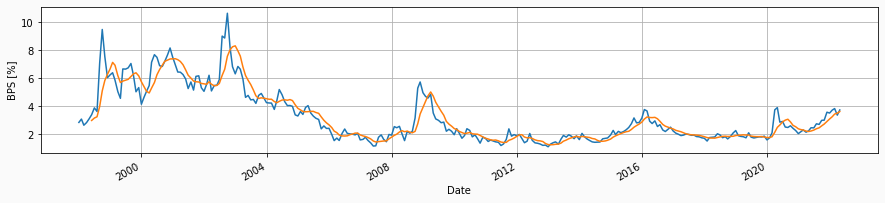

In [14]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3), facecolor=(.98, .98, .98))
fig4.suptitle('Plotting Moving Average', fontsize=14)

ax1 = df_embi.plot(use_index=True, y='Percentage Terms', style=['-'], ylabel='BPS [%]', legend=False, grid=True, ax=axes)
price_mean = df_embi['Percentage Terms'].rolling(6, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ylabel='BPS [%]', ax=axes)

## Exponential Smoothing

Seeking to reduce the noise of the data, the exponential smoothing filter allows to mitigate the noise without very large implications in the changes of time compared to the real data.

Given the low density of data, the displacement that the filter produces is much more noticeable, otherwise it happened in the EDA of the stoks.

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 432x288 with 0 Axes>

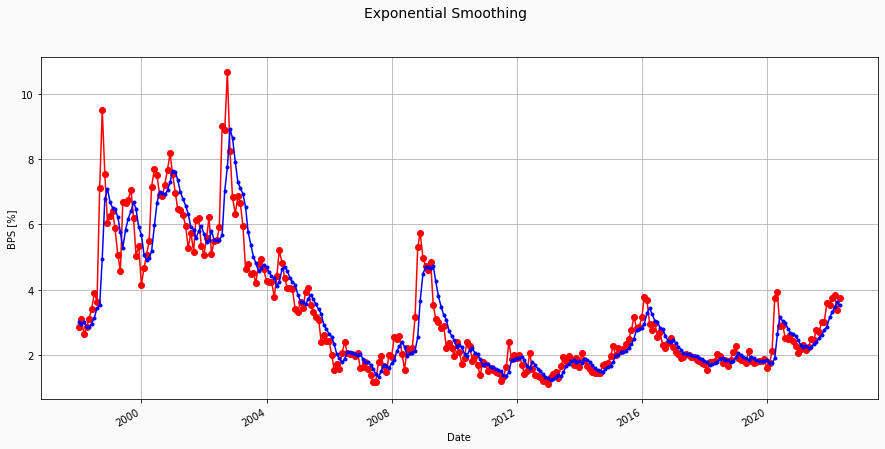

In [15]:
model = SimpleExpSmoothing(df_embi['Percentage Terms']).fit(smoothing_level=.4, optimized=True)

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Exponential Smoothing', fontsize=14)
ax = df_embi['Percentage Terms'].plot(marker='o', color='red', ylabel='BPS [%]', ax=axes);
model.fittedvalues.plot(marker='.', color='blue', grid=True, ax=axes);

## Lag plot 

Lag plot allows an analysis of percentage points between the observation of the sample in *t* and *t+1* where it is tried to verify if there is any pattern that shows that the series is not random, that is, to verify the existence of correlation between the samples. In the case of the BPS there is a positive but not very strong correlation.

<Figure size 432x288 with 0 Axes>

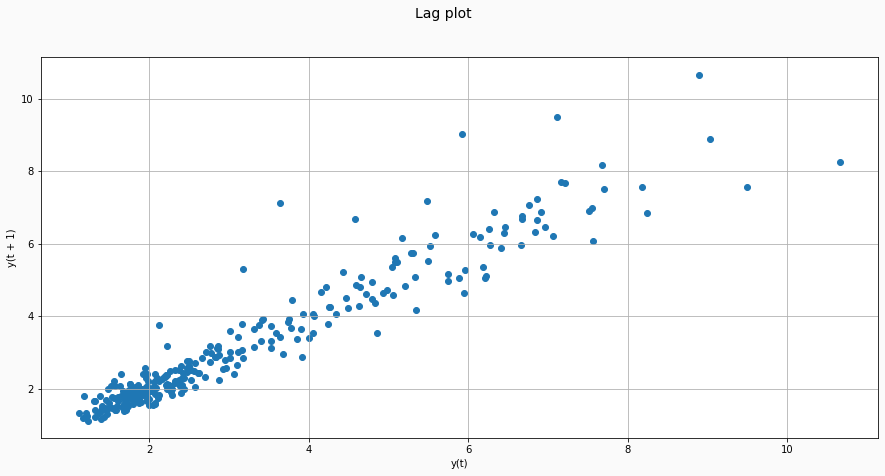

In [16]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Lag plot ', fontsize=14)
ax = lag_plot(df_embi['Percentage Terms'], lag=1, ax=axes);
ax.grid()

## Autocorrelation Plot

Finally, for the autocorrelation graph, it shows us how smoothly it tends towards low levels of correlation, since it is a series that has low correlation between samples.

<Figure size 432x288 with 0 Axes>

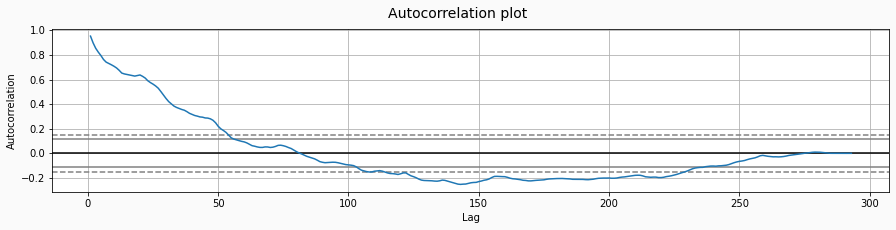

In [17]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3), facecolor=(.98, .98, .98))
fig.suptitle('Autocorrelation plot', fontsize=14)
autocorrelation_plot(df_embi['Percentage Terms'], ax=axes);

## Variation analysis of Emerging Markets Bond Index per year
The idea is to check if it is possible to find repetitive patterns in annual periods.

Text(0.5, 1.0, 'From 2017 to 2022')

<Figure size 432x288 with 0 Axes>

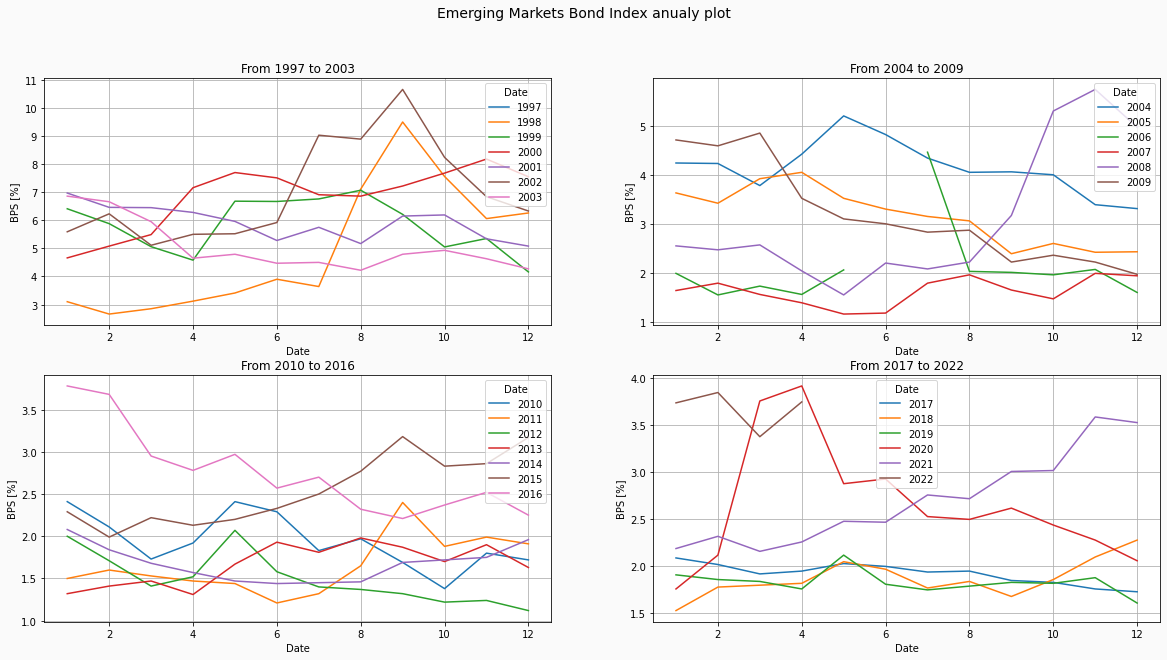

In [18]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), facecolor=(.98, .98, .98))
fig1.suptitle('Emerging Markets Bond Index anualy plot', fontsize=14)

df_aux = df_embi.loc[:'2003-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Percentage Terms', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='BPS [%]', grid=True, ax=axes1[0,0])
ax1.set_title('From 1997 to 2003')

df_aux = df_embi.loc['2004-01-01':'2009-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Percentage Terms', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='BPS [%]', grid=True, ax=axes1[0,1])
ax1.set_title('From 2004 to 2009')

df_aux = df_embi.loc['2010-01-01':'2016-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Percentage Terms', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='BPS [%]', grid=True, ax=axes1[1,0])
ax1.set_title('From 2010 to 2016')

df_aux = df_embi.loc['2017-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Percentage Terms', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='BPS [%]', grid=True, ax=axes1[1,1])
ax1.set_title('From 2017 to 2022')

Although there is no predominant or very noticeable pattern, increases are mainly seen in September, and in recent years rather low and stable values. Another important appreciation is the lack of data for June 2008.

## Seasonal subseries plot
Finally, an interesting analysis to carry out on the time series is an analysis of seasonal prices of percentage points, despite the fact that the first years have high variation, then a period of fall, after the stabilization that is preserved in the last years, holds more or less stable the average value per month.

In [19]:
years = df_embi['Year'].unique()
vol_yearly = pd.DataFrame()
PercentageTerms_yearly = pd.DataFrame()
for y in years:
    df_aux = df_embi[df_embi['Year']==y].groupby('Month')[['Percentage Terms']].mean()
    vol_yearly = pd.concat([vol_yearly, df_aux[['Percentage Terms']].T.set_index(pd.Index([y]))])
    PercentageTerms_yearly = pd.concat([PercentageTerms_yearly, df_aux[['Percentage Terms']].T.set_index(pd.Index([y]))])

In [20]:
vol_yearly_mean = pd.DataFrame()
PercentageTerms_yearly_mean = pd.DataFrame()
for y in years:
    vol_yearly_mean[y] = vol_yearly.mean()
    PercentageTerms_yearly_mean[y] = PercentageTerms_yearly.mean()

<Figure size 432x288 with 0 Axes>

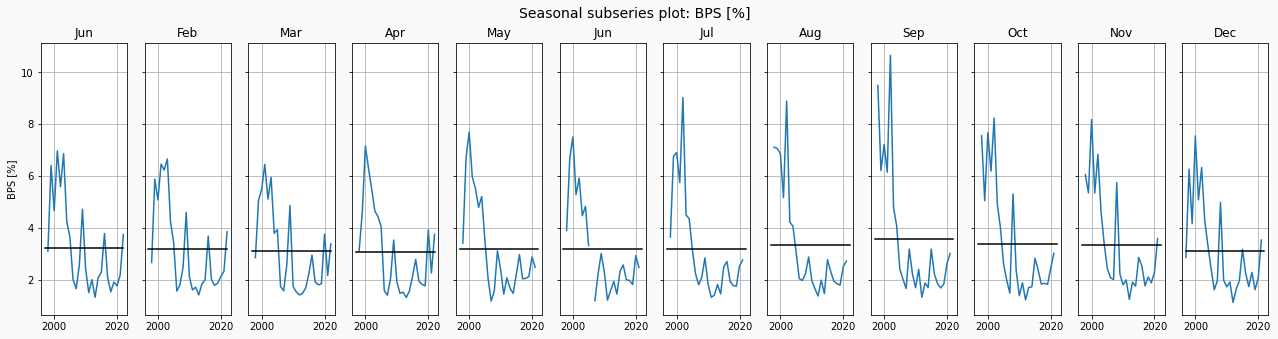

In [21]:
months = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot: BPS [%]', fontsize=14)
for i in PercentageTerms_yearly:
    PercentageTerms_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='BPS [%]', ax = axes1[i-1]);
    PercentageTerms_yearly_mean.T[i].plot(grid=True, legend=False, ax = axes1[i-1], color ='k');

In [22]:
path_out = '../data/dev/EMBI.csv'
df_embi.to_csv(path_out, encoding='utf-8')